In [106]:
import pandas as pd
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
#from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import IPython.display as ipd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.models as models

Importing augmentations

In [107]:
import augmentations

Setting config variables

In [108]:
MAX_LEN = 22000

In [109]:
df = pd.DataFrame(columns=['path', 'label', 'aug'])
# directory is bird_audio, subdirectories are the bird species, they have ogg files

# get the path of the audio files

import os
directory = 'bird_audio'
for subdir, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith('.ogg'):
            path = os.path.join(subdir, file)
            label = path.split('\\')[1]
            df = df._append({'path': path, 'label': label, "aug": None}, ignore_index=True)

Remember to only use augmentations for train and not for test

In [110]:
df.describe()

,path,label,aug
count,24459,24459,0
unique,24459,182,0
top,bird_audio\asbfly\XC134896.ogg,zitcis1,NaN
freq,1,500,NaN


In [111]:
torchaudio.load(df['path'][0]) # sig, sr

(tensor([[ 1.3738e-06,  9.2571e-07, -2.7169e-06,  ...,  6.2166e-06,
          -1.4831e-06, -3.4762e-06]]),
 32000)

In [112]:
torchaudio.load(df['path'][0])[0].shape

torch.Size([1, 875207])

In [113]:
class AugmentedTrainDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.length = df.shape[0]
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):

        path = self.df['path'][idx]
        label = self.df['label'][idx]
        #label = torch.tensor(label, dtype=torch.long)
        aud, sr = torchaudio.load(path)
        #do time domain stuff
        aud, sr = augmentations.pad_trunc((aud, sr), MAX_LEN)
        

        spectro = transforms.MelSpectrogram()(aud)
        spectro = transforms.AmplitudeToDB()(spectro)
        spectro_m, spectro_s = spectro.mean(), spectro.std()
        spectro = (spectro - spectro_m) / spectro_s
        #do frequency domain stuff
        

        return spectro, label

In [114]:
class TestDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.length = df.shape[0]
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):

        path = self.df['path'][idx]
        label = self.df['label'][idx]
        label = torch.tensor(label, dtype=torch.long)
        aud, sr = torchaudio.load(path)
        #DO NOT AUGMENT, ONLY NORMALIZE (and other things like pad, trunc if needed)
        #do time domain stuff
        aud, sr = augmentations.pad_trunc((aud, sr), MAX_LEN)
        

        spectro = transforms.MelSpectrogram()(aud)
        spectro = transforms.AmplitudeToDB()(spectro)
        spectro_m, spectro_s = spectro.mean(), spectro.std()
        spectro = (spectro - spectro_m) / spectro_s
        #do frequency domain stuff
        

        return spectro, label

In [115]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2)

train_dataset = AugmentedTrainDataset(train_df.reset_index(drop=True))
test_dataset = AugmentedTrainDataset(test_df.reset_index(drop=True))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

whcbar1


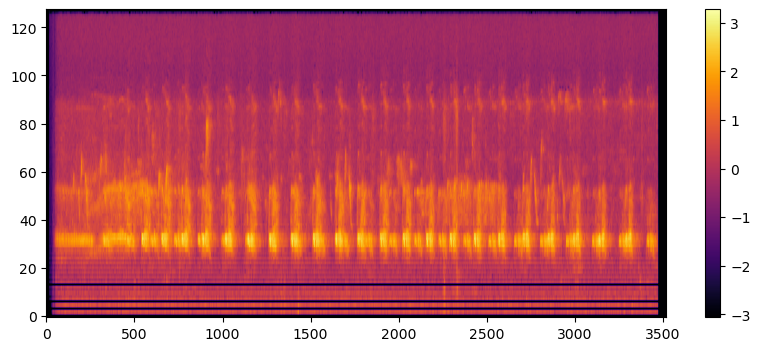

In [131]:
exampleplot = next(iter(train_loader))
plt.figure(figsize=(10, 4))
plt.imshow(exampleplot[0][0][0].numpy(), aspect='auto', origin='lower', cmap='inferno')
plt.colorbar()
print(exampleplot[1][0])

'commyn'